In [1]:
from datetime import datetime

import numpy as np

from btopt import Engine, ExtendedDecimal, Order, Strategy
from btopt.indicators import SimpleMovingAverage
from btopt.util import logger_test, logger_main

In [2]:
def parse_date(epoch):
    return datetime.fromtimestamp(epoch / 1_000_000_000).strftime("%Y-%m-%d %H:%M:%S")


class SimpleMovingAverageCrossover(Strategy):
    def __init__(self, fast_period: int = 20, slow_period: int = 50, risk_percent=0.01):
        super().__init__()

        self.fast_ma = 0
        self.slow_ma = 0

        self.risk_percentage = risk_percent
        self.fast_sma = SimpleMovingAverage(
            name="SMA_FAST",
            period=fast_period,
            source="close",
        )
        self.slow_sma = SimpleMovingAverage(
            name="SMA_SLOW",
            period=slow_period,
            source="close",
        )

        self.add_indicator(self.fast_sma)
        self.add_indicator(self.slow_sma)

        self.total = 0

    def on_data(self) -> None:
        bar = self.datas[self._primary_symbol].get(index=0)
        fast_ma = self.fast_sma.outputs[self._primary_symbol]["sma"][0]
        slow_ma = self.slow_sma.outputs[self._primary_symbol]["sma"][0]

        fast_ma_1 = self.fast_sma.outputs[self._primary_symbol]["sma"][1]
        slow_ma_1 = self.slow_sma.outputs[self._primary_symbol]["sma"][1]

        current_position = self.get_current_position(bar.ticker)

        if (not np.isnan(fast_ma_1)) and (not np.isnan(slow_ma_1)):
            prev_diff = fast_ma_1 - slow_ma_1
            diff = fast_ma - slow_ma

            if (diff > 0) and (prev_diff <= 0):
                # Bullish crossover
                if current_position == 0:
                    position_size = self.calculate_position_size(
                        bar.ticker,
                        bar.close,
                    )

                    size = abs(current_position) + position_size
                    order = self.buy(
                        bar.ticker,
                        size,
                        stop_loss=bar.close * 0.97,
                        take_profit=bar.close * 1.01,
                    )

                    logger_main.warning(f"\n\n----- NEW SIGNAL -----\n {order}\n\n")
                    self.total += 1
            elif (diff < 0) and (prev_diff >= 0):
                # Bearish crossover
                if current_position == 0:
                    position_size = self.calculate_position_size(
                        bar.ticker,
                        bar.close,
                    )

                    size = abs(current_position) + position_size
                    order = self.sell(
                        bar.ticker,
                        size,
                        stop_loss=bar.close * 1.03,
                        take_profit=bar.close * 0.99,
                    )
                    logger_main.warning(f"\n\n----- NEW SIGNAL -----\n {order}\n\n")
                    self.total += 1

    def on_order_update(self, order: Order) -> None:
        # if order.status == order.Status.CREATED and order.details.exectype in [
        #     Order.ExecType.EXIT_LIMIT,
        #     Order.ExecType.EXIT_STOP,
        # ]:
        #     logger_test.info(
        #         f"Order {order.id} Created | Price = {order.get_last_fill_price()}; Direction: {order.details.direction}"
        #     )
        ...

    def on_trade_update(self, trade) -> None:
        if trade.status == trade.Status.CLOSED:
            logger_test.info(
                f"--------- TRADE COMPLETED -----------\n\
                ID: {trade.id}\n\
                DIRECTION: {trade.direction}\n\
                SIZE: {trade.initial_size}\n\n\
                ENTRY_TIME: {trade.entry_timestamp}\n\
                ENTRY_PRICE: {trade.entry_price}\n\
                TP_PRICE: {trade.entry_price * 1.01 if trade.direction == Order.Direction.LONG else trade.entry_price * 0.99}\n\
                SL_PRICE: {trade.entry_price * 0.97 if trade.direction == Order.Direction.LONG else trade.entry_price * 1.03}\n\n\
                EXIT_TIME: {trade.exit_timestamp}\n\
                EXIT_PRICE: {trade.exit_price}\n\
                PNL: {trade.metrics.pnl}\n\
                ---------------------------------------\n\
                \n\n\
                "
            )

In [3]:
from btopt.data.dataloader import CSVDataLoader


def run_backtest():
    # Initialize the engine
    engine = Engine()

    # Load data

    start_date = "2024-01-01"
    end_date = "2024-05-31"

    symbol = "BTCUSDT"
    dataloader = CSVDataLoader(symbol, "1m", start_date=start_date, end_date=end_date)
    engine.resample_data(dataloader, "1h")

    # symbol = "ES=F"
    # dataloader = YFDataloader(symbol, "1d", start_date=start_date, end_date=end_date)
    # engine.add_data(dataloader)

    # engine.add_strategy(Empty, ctf, htf)
    engine.add_strategy(SimpleMovingAverageCrossover, fast_period=20, slow_period=50)

    # Set up the backtest configuration

    initial_capital = ExtendedDecimal("100000")
    commission_rate = ExtendedDecimal("0")
    config = {
        "initial_capital": initial_capital,
        "commission_rate": commission_rate,
    }
    engine.set_config(config)

    # Run the backtest
    try:
        logger_test.info("Starting backtest")
        reporter = engine.run()

        return reporter
    except Exception as e:
        logger_test.error(f"Error during backtest: {e}", exc_info=True)

In [4]:
reporter = run_backtest()

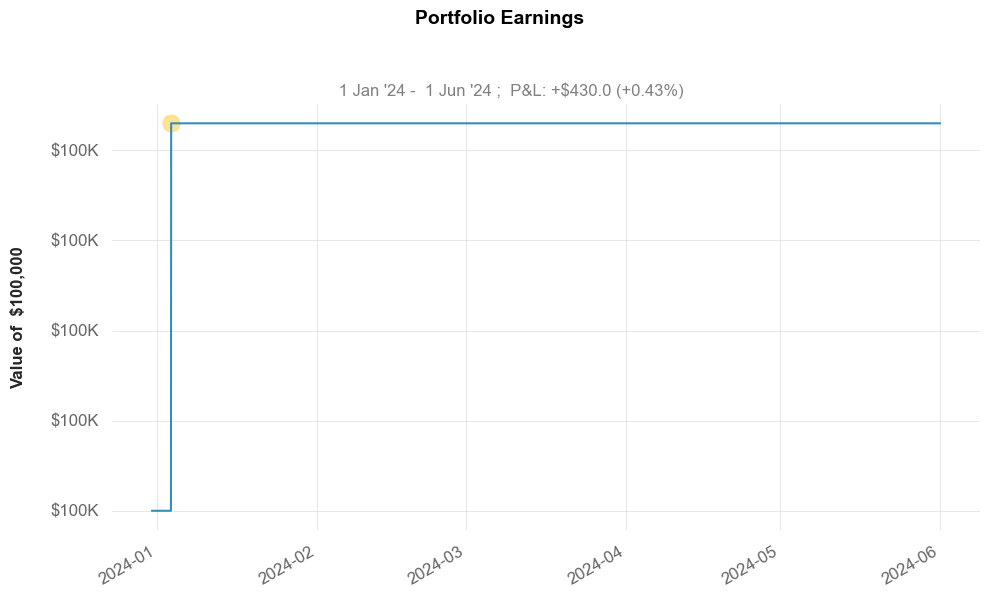

In [5]:
reporter.plot_equity_curve()